# hetan: ridge regression on macro variables and a basket of related stocks is what i’d suggest

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import pandas_datareader as pdr
import quantstats as qs
import pytz

import datetime as dt

from sklearn import linear_model
'''
snp_data = pd.read_csv('../Data/snp500.csv')
snp = pd.Series(snp_data[['Symbol']].squeeze()).tolist()
'''

"\nsnp_data = pd.read_csv('../Data/snp500.csv')\nsnp = pd.Series(snp_data[['Symbol']].squeeze()).tolist()\n"

In [14]:
snp_data = pd.read_csv('../Data/snp500.csv')
snp = pd.Series(snp_data[['Symbol']].squeeze()).tolist()

# Try Hetan's suggestion - rough generalization of pairs trading on multiple assets

In [15]:
# tickerName: string, a single ticker
# period can be '_mo', '_
def downloadClosingPrices(tickerName, period='6mo'):
    return yf.Ticker(tickerName).history(period=period)[['Close']]

# closingPrices: a Pandas Dataframe of closing prices
# returns a list of returns
def getReturns(closingPrices):
    return closingPrices.pct_change(1).dropna() #closingPrices.diff().reset_index(drop=True)[1:].reset_index(drop=True).div(closingPrices[:-1].reset_index(drop=True))

# tickerNames: a list of strings of ticker names
# returns a dictionary of ticker names to lists of their daily returns
def makeDailyReturnsDf(tickerNames, period='6mo'):
    ticker_data = {}
  
    longestIndex = pd.Series(dtype='float64')
    # retrieve data
    for t in tickerNames:
        # take over the past 6 months
        c = downloadClosingPrices(t, period)
        if len(c.index) >= len(longestIndex):
            longestIndex = c.index[1:]
        # No data found, symbol may be delisted
        if len(c) == 0:
            continue
        else:
            ticker_data[t] = getReturns(c).rename(columns={"Close":t}).squeeze().tolist()
    # remove stocks which are not of the same length
    lens = [len(v) for v in ticker_data.values()]
    # print(lens)
    longest = pd.Series(lens).value_counts().max()
    ticker_data_copy = ticker_data.copy()
    for k, v in ticker_data_copy.items():
        if len(v) < longest:
            ticker_data.pop(k)
    return pd.DataFrame(ticker_data, index = longestIndex)

# tickersToPredict DOESN'T have to be a subset of tickers
# returns a dictionary with the name of the stock as keys and the LM predicting that stock as values
# trains pair-wise LMs using same-day returns of related stocks as predictors
def trainLM(tickers, tickerToPredict):

    X = makeDailyReturnsDf(tickers)
    y = makeDailyReturnsDf([tickerToPredict])

    lm = Ridge()
    if tickerToPredict in X.columns:
        X.drop(columns=tickerToPredict, inplace=True)
    lm.fit(X, y)
    print(tickerToPredict, lm.score(X, y))
    return lm

In [16]:
# TODO: change to return series?
## zscore fn to generate buy/sell signals on a daily basis
# takes the zscore of a particular day's prediction over a window of past days
# lm: the linear model predicting stock returns based on related stocks
# X: a dataframe of predictors - returns of stocks related to the target
# y: a list of the target stock's returns
# days: number of days back to scale over
def zscore(lm, X, y, days=30):
    # lookback = min(len(X), len(y), days)
    lookback = days
    # print('lookback',lookback)
    steps = len(X)
    z_ts = []
    for s in range(steps,lookback,-1):
        X_window, y_window = X.iloc[s-lookback:s,], y.iloc[s-lookback:s]
        # predict for the last lookback no. of days
        y_hats = lm.predict(X_window)
        # get the residuals
        y_res = y_window - y_hats

        # get residual for today
        y_res_t = y_res.iloc[-1]
        y_res_ex_t = y_res.iloc[:-1]

        scaler = StandardScaler()
        # fit scale based on residuals up to yesterday
        scaler.fit(np.asarray(y_res_ex_t).reshape(-1,1))

        # transform today's residual
        z_t = scaler.transform(np.asarray(y_res_t).reshape(-1,1))
        z_ts.append(z_t[0][0])
    return z_ts

In [17]:
# vectorized, zscore becomes an array
def getBuySellWeightsVectorized(lm, zscores, predictedStockName):
  weights_list = list()
  coefs = lm.coef_[0]
  feature_names = lm.feature_names_in_

  for i in range(len(zscores)):
    zscore = zscores[i]
    weights = dict()
    # take action only if it is 1.5 SDs away from the mean
    if abs(zscore) > 1:
      # if zscore is positive, the stock is overvalued today, so we should sell the predicted stock and buy the predictor stocks
      isPositive = zscore >= 0
      if isPositive:
        weights[predictedStockName] = -1
        for feat,coef in zip(feature_names, coefs):
          weights[feat] = coef/sum(coefs)
      # if zscore is negative, the predicted stock is undervalued, so we should buy the predicted stock and sell the predictor stocks
      else:
        weights[predictedStockName] = 1
        for feat,coef in zip(feature_names, coefs):
          weights[feat] = -coef/sum(coefs)
    # take no action if the misvaluation is not strong enough
    else:
      if i > 0:
        weights = weights_list[i-1]
      else:
        weights[predictedStockName] = 1/(len(feature_names)+1)
        for feat in feature_names:
          weights[feat] = 1/(len(feature_names)+1)
      # weights = dict(zip(feature_names, [0]*len(feature_names)))
    weights_list.append(weights)
  return pd.DataFrame(weights_list)

## Test Model

In [11]:
meta_lm = trainLM(tickers5,'META')

NameError: name 'tickers5' is not defined

In [ ]:
tickers5_df = makeDailyReturnsDf(tickers5)
meta_df = makeDailyReturnsDf(['META'])

In [ ]:
tickers5_df

,META,AAPL,MSFT,TWTR,IBM
Date,,,,,
2022-04-22,-0.021056,-0.027821,-0.024144,0.039295,-0.011441
2022-04-25,0.015643,0.006737,0.024413,0.056611,0.006148
2022-04-26,-0.032301,-0.037328,-0.037404,-0.039072,-0.020920
2022-04-27,-0.033158,-0.001467,0.048109,-0.020934,-0.008297
2022-04-28,0.175936,0.045155,0.022633,0.009663,0.005035
...,...,...,...,...,...
2022-10-14,-0.027093,-0.032240,-0.024249,0.002185,-0.014369
2022-10-17,0.057431,0.029123,0.039246,0.005748,0.012329
2022-10-18,-0.009251,0.009409,0.004084,0.020497,0.011685


In [ ]:
meta_lm

Ridge()

In [ ]:
z_ts = zscore(meta_lm, tickers5_df.drop(columns='META'), meta_df)
# meta_lm.predict(tickers5_df.drop(columns='META'))
len(z_ts)

96

## Feed the top technology stocks as predictors

In [ ]:
# Input tickers
tickers_toptech = ["META", "AMZN", "GOOG", "AAPL", "MSFT", "TSLA", "NVDA", "BABA", "CRM", "INTC", "PYPL", "AMD", "ATVI", "EA", "TTD", "MTCH", "ZG", "YELP"]
lms_toptech = []
for t in tickers5:
    lms_toptech.append(trainLM(tickers_toptech, t))


META 0.5865143555507238
AAPL 0.5721774847945177
MSFT 0.5769296048031916
TWTR 0.12177086542435467
IBM 0.1699698832746226


## Feed all S&P500 stock as predictors

In [ ]:
lms_snp = trainLMs(snp, tickers5)

- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
1.3873424216633616
META 0.7187626691710545
1.5219653130468063
AMZN 0.7801922692139592
1.0337876364953575
GOOG 0.7977872373442941
0.26159641104156867
AAPL 0.7862581188003093
1.3036929639806274
MSFT 0.8081925669862813


In [ ]:
snp_df = makeDailyReturnsDf(snp)

In [ ]:
# lms_snp['META'].score(makeDailyReturnsDf(snp),makeDailyReturnsDf(["META"]))

## Feed all IT stocks as predictors

In [18]:
tickers_it = snp_data[snp_data['GICS Sector'] == 'Information Technology']['Symbol'].to_list()
tickers5 = ['META','AAPL', 'GOOG', 'AMZN', 'TSLA']

In [ ]:
# lms_it = trainLMs(tickers_it, tickers5)
lm_meta_it = trainLM(tickers_it, "META")

META 0.599147728751007


## Backtest

In [20]:
lm_meta = trainLM(tickers5, "META")

META 0.24180738808893876


In [21]:
Xhist = makeDailyReturnsDf([t for t in tickers5 if t != "META"], '4y')
yhist = makeDailyReturnsDf(["META"],'4y')
# z_meta = zscore(lm_meta, Xhist, yhist)
# print(len(z_meta))

Get buy sell weights from zscores

In [ ]:
weights_df = getBuySellWeightsVectorized(lm_meta, z_meta, "META")

In [ ]:
weights_df

,META,GOOG,AMZN,MSFT,AAPL
0,0.2,0.200000,0.20000,0.200000,0.200000
1,0.2,0.200000,0.20000,0.200000,0.200000
2,0.2,0.200000,0.20000,0.200000,0.200000
3,-1.0,0.271494,0.30772,0.199053,0.221733
4,-1.0,0.271494,0.30772,0.199053,0.221733
...,...,...,...,...,...
971,1.0,-0.271494,-0.30772,-0.199053,-0.221733
972,1.0,-0.271494,-0.30772,-0.199053,-0.221733
973,-1.0,0.271494,0.30772,0.199053,0.221733
974,-1.0,0.271494,0.30772,0.199053,0.221733


In [ ]:
# Xhist = Xhist[len(Xhist)-len(weights_df):]
# yhist = yhist[len(yhist)-len(weights_df):]

In [26]:
Xyhist = pd.concat([Xhist, yhist],axis=1)
print(sum(Xhist.index == yhist.index))
Xyhist

1005


,GOOG,AMZN,MSFT,AAPL,META
Date,,,,,
2018-10-29 00:00:00-04:00,-0.047962,-0.063264,-0.029076,-0.018770,-0.022563
2018-10-30 00:00:00-04:00,0.015812,-0.005497,-0.001155,0.004994,0.029066
2018-10-31 00:00:00-04:00,0.039143,0.044164,0.029692,0.026067,0.038093
2018-11-01 00:00:00-04:00,-0.006287,0.042253,-0.008333,0.015352,-0.000263
2018-11-02 00:00:00-04:00,-0.011411,0.000000,0.002266,-0.066331,-0.009226
...,...,...,...,...,...
2022-10-19 00:00:00-04:00,-0.010849,-0.011086,-0.008470,0.000765,0.003238
2022-10-20 00:00:00-04:00,0.002393,0.001564,-0.001395,-0.003267,-0.012760
2022-10-21 00:00:00-04:00,0.009450,0.035315,0.025281,0.027059,-0.011556


In [22]:
spy = makeDailyReturnsDf(["SPY"], '4y')
spy

,SPY
Date,
2018-10-29 00:00:00-04:00,-0.005540
2018-10-30 00:00:00-04:00,0.014818
2018-10-31 00:00:00-04:00,0.010681
2018-11-01 00:00:00-04:00,0.010642
2018-11-02 00:00:00-04:00,-0.005923
...,...
2022-10-19 00:00:00-04:00,-0.007086
2022-10-20 00:00:00-04:00,-0.008385
2022-10-21 00:00:00-04:00,0.024301


In [ ]:
print(sum(weights_df.index == Xyhist.index))
print(weights_df)
weights_df.index = Xyhist.index
weights_df

0
     META      GOOG     AMZN      MSFT      AAPL
0     0.2  0.200000  0.20000  0.200000  0.200000
1     0.2  0.200000  0.20000  0.200000  0.200000
2     0.2  0.200000  0.20000  0.200000  0.200000
3    -1.0  0.271494  0.30772  0.199053  0.221733
4    -1.0  0.271494  0.30772  0.199053  0.221733
..    ...       ...      ...       ...       ...
971   1.0 -0.271494 -0.30772 -0.199053 -0.221733
972   1.0 -0.271494 -0.30772 -0.199053 -0.221733
973  -1.0  0.271494  0.30772  0.199053  0.221733
974  -1.0  0.271494  0.30772  0.199053  0.221733
975  -1.0  0.271494  0.30772  0.199053  0.221733

[976 rows x 5 columns]


,META,GOOG,AMZN,MSFT,AAPL
Date,,,,,
2018-12-06 00:00:00-05:00,0.2,0.200000,0.20000,0.200000,0.200000
2018-12-07 00:00:00-05:00,0.2,0.200000,0.20000,0.200000,0.200000
2018-12-10 00:00:00-05:00,0.2,0.200000,0.20000,0.200000,0.200000
2018-12-11 00:00:00-05:00,-1.0,0.271494,0.30772,0.199053,0.221733
2018-12-12 00:00:00-05:00,-1.0,0.271494,0.30772,0.199053,0.221733
...,...,...,...,...,...
2022-10-14 00:00:00-04:00,1.0,-0.271494,-0.30772,-0.199053,-0.221733
2022-10-17 00:00:00-04:00,1.0,-0.271494,-0.30772,-0.199053,-0.221733
2022-10-18 00:00:00-04:00,-1.0,0.271494,0.30772,0.199053,0.221733


# Hetan's intervention!! (Part 1 - Buggy)

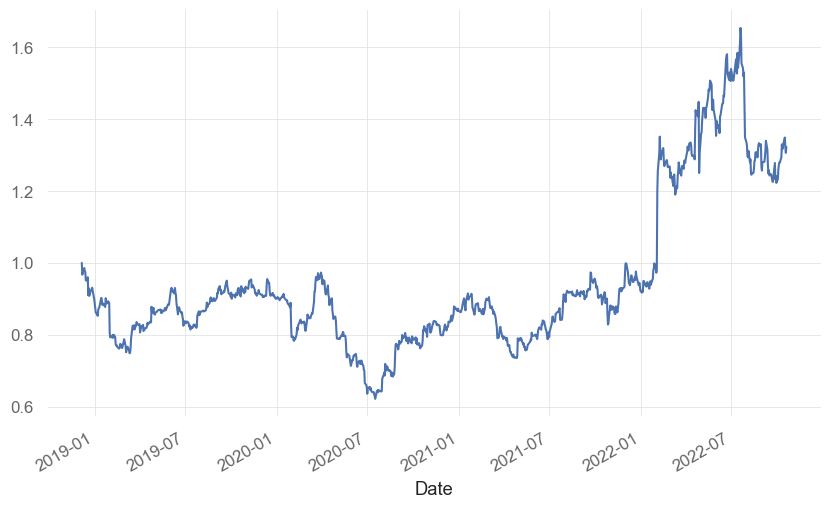

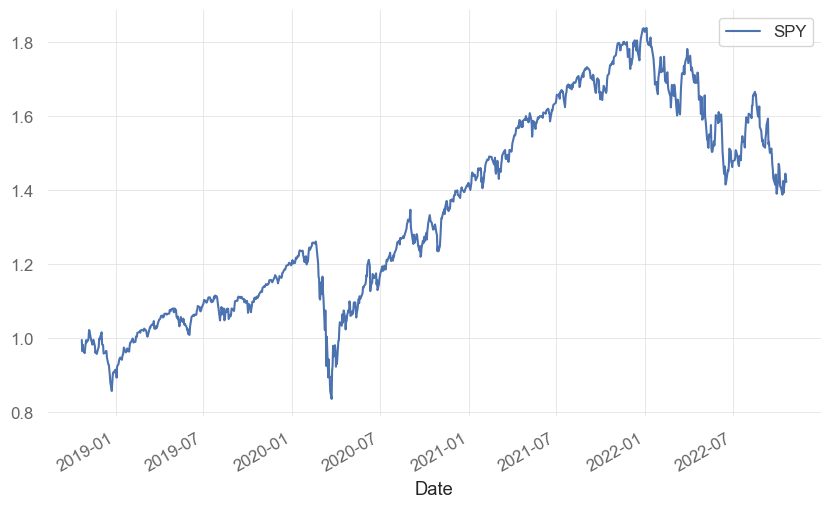

In [ ]:
# portfolio = (weights_df.shift(1) * Xyhist.pct_change(1)).sum(1)
retsPortfolio = (weights_df.shift(1) * Xyhist).sum(1)
(1+retsPortfolio).cumprod().plot(label='model')
(1+spy).cumprod().plot(label='SPY')
plt.legend()

<AxesSubplot:xlabel='Date'>

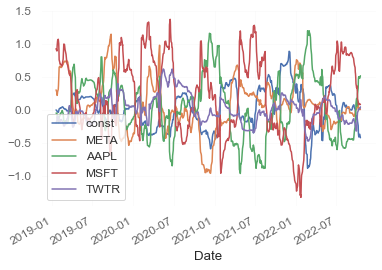

In [ ]:
betas.plot()

<AxesSubplot:xlabel='Date'>

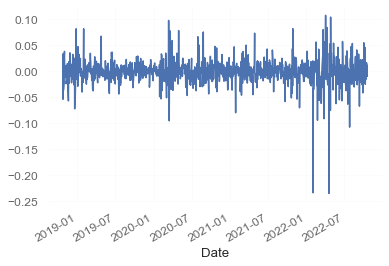

In [ ]:
(yhist[tick] - (betas * (Xhist)).sum(1)).plot()

<AxesSubplot:xlabel='Date'>

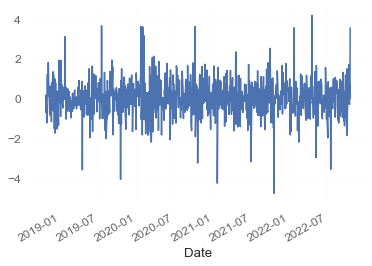

In [ ]:
zscore.plot()

In [ ]:
betas

,META,AAPL,MSFT,TWTR
Date,,,,
2019-04-16,0.373836,-0.085253,0.416918,-0.123993
2019-04-17,0.374988,-0.089564,0.413850,-0.121599
2019-04-18,0.373325,-0.102849,0.418987,-0.104839
2019-04-22,0.375891,-0.107476,0.412829,-0.103805
2019-04-23,0.369888,-0.110700,0.408035,-0.111376
...,...,...,...,...
2022-10-14,-0.013085,-0.284893,0.584649,-0.117373
2022-10-17,-0.014762,-0.282779,0.581535,-0.120924
2022-10-18,-0.017735,-0.285272,0.582577,-0.114416


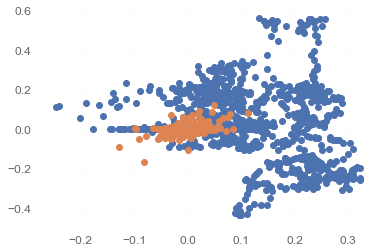

In [ ]:
plt.scatter(logPriceFromRets(yhist[tick]),(betas * logPriceFromRets(Xhist)).sum(1))
plt.scatter((yhist[tick]),(betas * (Xhist)).sum(1))

In [ ]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm
window = 120
lookback = 30
thresh = 1
rets = True

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

retsSpreads = []
for tick in tqdm(tickers5):
    Xhist = makeDailyReturnsDf([t for t in tickers5 if t != tick], '4y')
    yhist = makeDailyReturnsDf([tick],'4y')
    if rets:
        betas = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit().params.dropna().iloc[:,1:]
    else:
        betas = RollingOLS(logPriceFromRets(yhist), 
                           sm.add_constant(logPriceFromRets(Xhist)), window=window).fit().params.dropna().iloc[:,1:]
    norm = 1+betas.abs().sum(1)
    betas = betas.div(norm,0)
    spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
    zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
    signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
    weights = betas.mul(signals,0).shift(1)
    #weights[[ticker for ticker in tickers5 if ticker != tick]] = 0
    weights[tick] = signals.shift(1)/norm
    retsSpreads.append((weights * 
                        Xyhist.reindex(betas.index).dropna()).sum(1))
retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna()
qs.reports.full(retsSpreads.mean(1), rf=0.02, benchmark='SPY', match_dates=True)

NameError: name 'tickers5' is not defined

<AxesSubplot:xlabel='Date'>

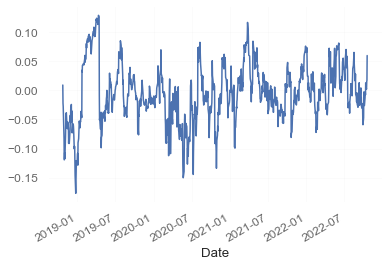

In [ ]:
spread.plot()

<AxesSubplot:xlabel='Date'>

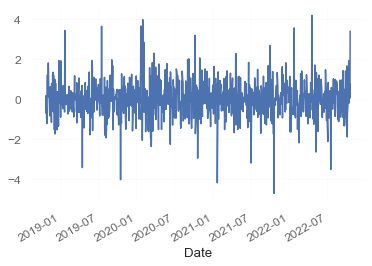

In [ ]:
zscore.plot()

# Hetan's intervention!! (Part 2)

In [23]:
tickers5 = ["META", "GOOG", "AMZN", "MSFT", "AAPL"]

100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


                           Strategy
-------------------------  ----------
Start Period               2019-04-23
End Period                 2022-10-25
Risk-Free Rate             2.0%
Time in Market             100.0%

Cumulative Return          47.21%
CAGR﹪                     11.65%

Sharpe                     0.5
Prob. Sharpe Ratio         68.72%
Smart Sharpe               0.42
Sortino                    0.7
Smart Sortino              0.59
Sortino/√2                 0.49
Smart Sortino/√2           0.42
Omega                      1.1

Max Drawdown               -29.52%
Longest DD Days            316
Volatility (ann.)          23.99%
Calmar                     0.39
Skew                       -0.06
Kurtosis                   6.32

Expected Daily %           0.04%
Expected Monthly %         0.9%
Expected Yearly %          10.15%
Kelly Criterion            5.58%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.43%
Expected Shortfall (cVaR)  -2.43%

Max Consecutive Wins       1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-12-13,2022-10-12,2022-10-25,316,-29.517872,-28.837343
2,2020-02-20,2020-03-12,2020-05-07,77,-24.517494,-22.093346
3,2019-04-30,2019-06-03,2019-11-27,211,-12.304115,-10.745371
4,2020-09-03,2020-09-18,2020-11-05,63,-10.984978,-10.804584
5,2020-12-29,2021-03-08,2021-04-07,99,-8.434015,-7.705765


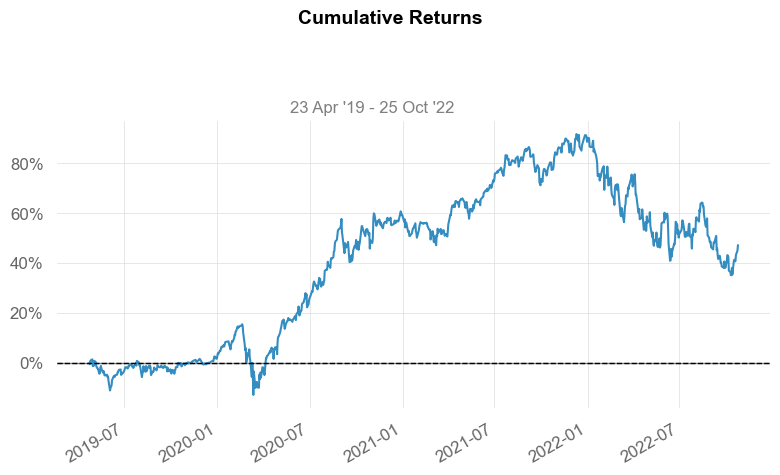

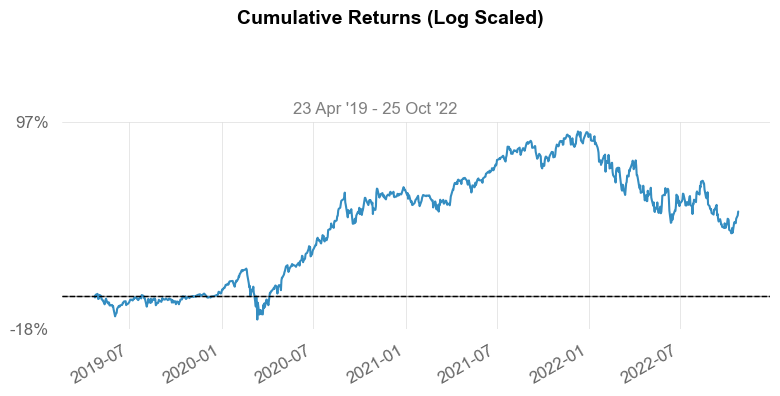

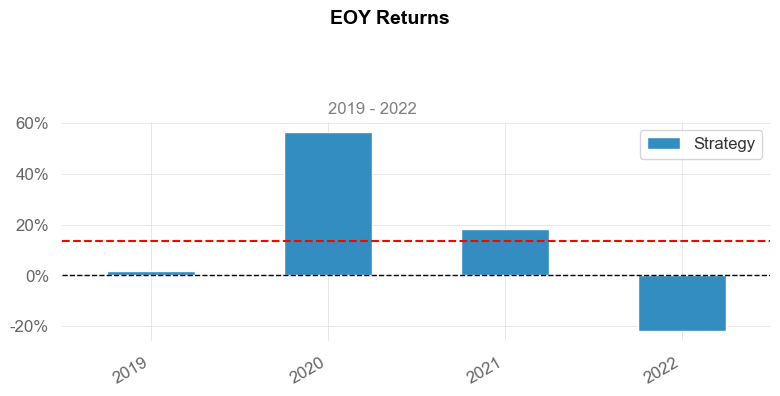

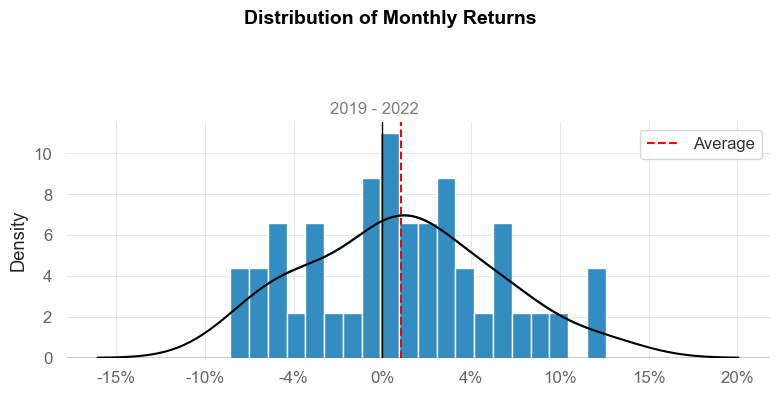

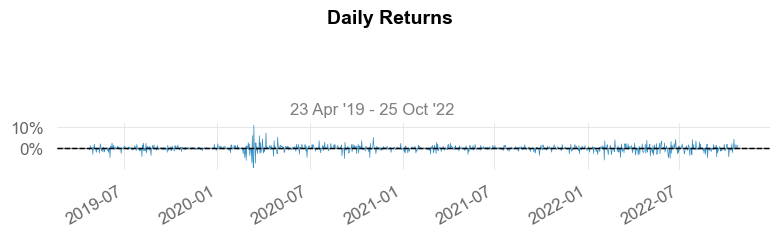

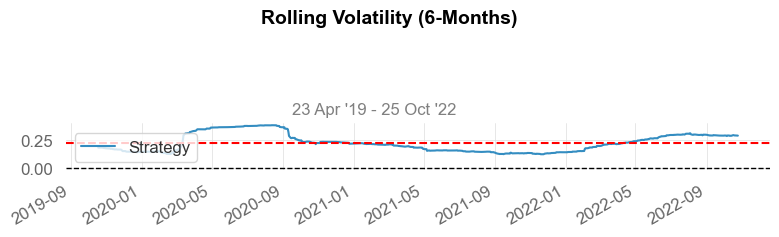

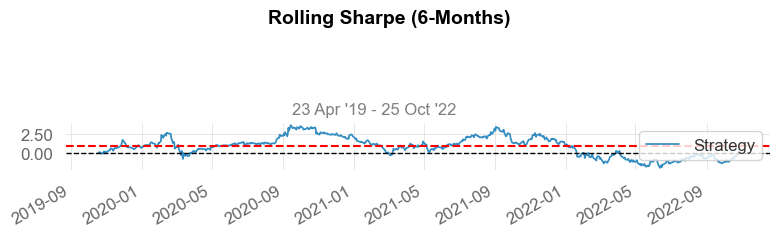

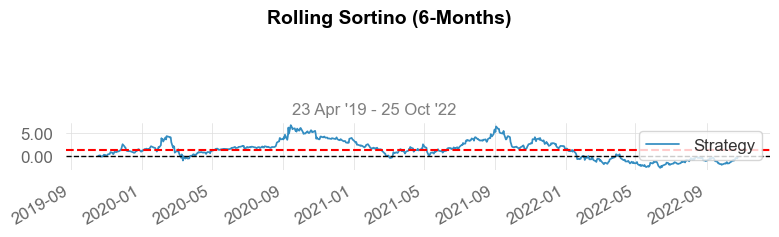

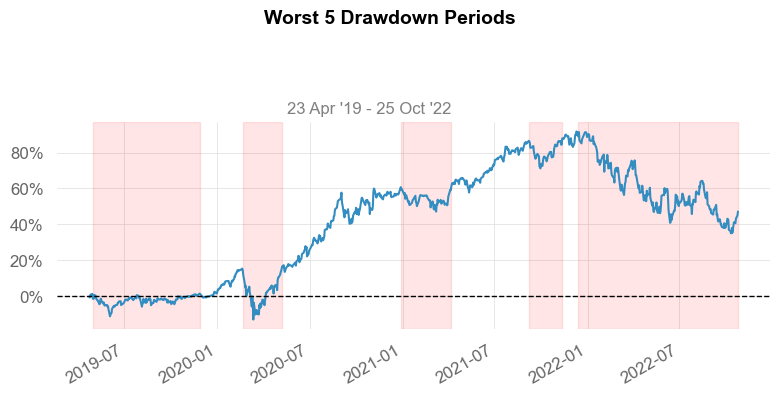

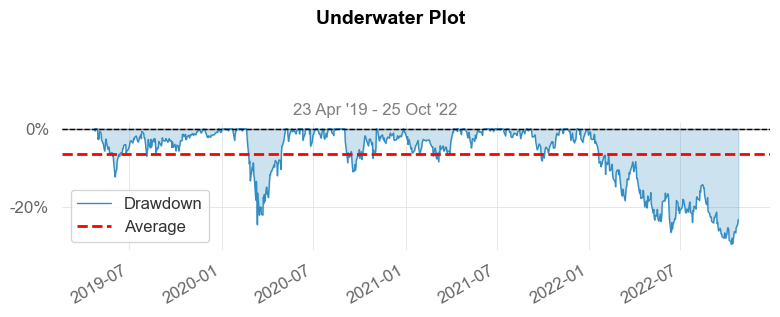

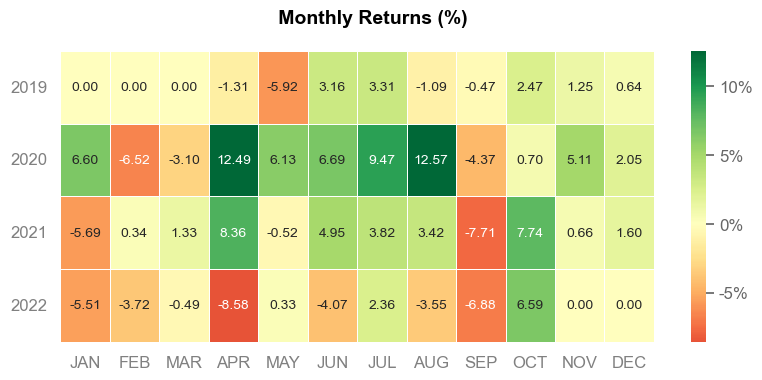

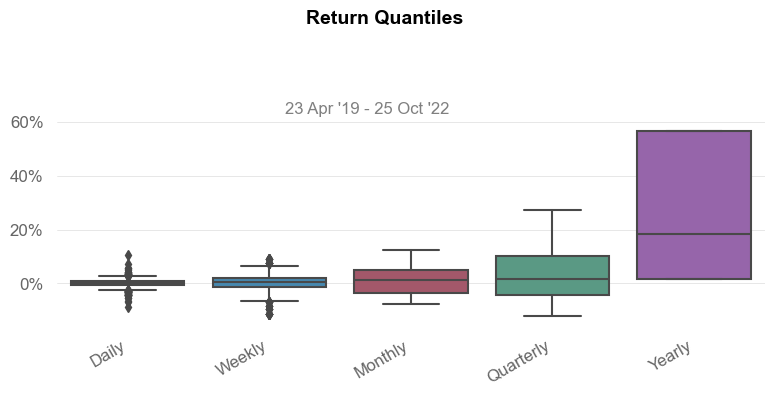

In [31]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm
window = 120
lookback = 30
thresh = 1
rets = True
intercept = False

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

retsSpreads = []
for tick in tqdm(tickers5):
    Xhist = makeDailyReturnsDf([t for t in tickers5 if t != tick], '4y')
    yhist = makeDailyReturnsDf([tick],'4y')
    if rets:
        if intercept:
            ols = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit()
        else:
            ols = RollingOLS(yhist, Xhist, window=window).fit()
        betas = ols.params.dropna()
    else:
        if intercept:
            ols = RollingOLS(logPriceFromRets(yhist), 
                           sm.add_constant(logPriceFromRets(Xhist)), window=window).fit()
        else:
            ols = RollingOLS(logPriceFromRets(yhist), 
                           logPriceFromRets(Xhist), window=window).fit()
        betas = ols.params.dropna()
    if intercept:
        if rets:
            spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
        else:
            spread = logPriceFromRets(yhist[tick]) - (betas * sm.add_constant(logPriceFromRets(Xhist))).sum(1)
        weights = sm.add_constant(betas.drop('const', axis=1)).rename({'const':tick}, axis=1)
        weights = weights.div(weights.abs().sum(1), axis=0)
    else:
        if rets:
            spread = yhist[tick] - (betas * (Xhist)).sum(1)
        else:
            spread = logPriceFromRets(yhist[tick]) - (betas * logPriceFromRets(Xhist)).sum(1)
        weights = sm.add_constant(betas).rename({'const':tick}, axis=1)
        weights = weights.div(weights.abs().sum(1), axis=0)
    zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
    signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
    retsSpreads.append((weights.mul(signals,0).shift(1) * 
                        Xyhist.reindex(betas.index).dropna()).sum(1))
retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna().reset_index()
retsSpreads['Date'] = retsSpreads['Date'].dt.tz_localize(None)
retsSpreads.index = retsSpreads['Date']
retsSpreads.drop(columns=['Date'], inplace=True)
qs.reports.full(retsSpreads.mean(1), rf=0.02, match_dates=True) #benchmark='SPY'

In [ ]:
from eod import EodHistoricalData
eastern = pytz.timezone('US/Eastern')
api_key = "6149ef1b322b37.04228930"
client = EodHistoricalData(api_key)
tickers = ['SPY']
prices = {}
for tick in tickers:
    data = pd.DataFrame(client.get_prices_eod(tick))
    data.index = pd.to_datetime(data['date'])
    data = data.drop('date', 1)
    prices[tick] = data

/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_1065/4114831500.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('date', 1)


In [ ]:
adjclose = pd.DataFrame({tick: prices[tick]['adjusted_close'] for tick in tickers}).dropna()
adjclose.index

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2022-10-05', '2022-10-06', '2022-10-07', '2022-10-10',
               '2022-10-11', '2022-10-12', '2022-10-13', '2022-10-14',
               '2022-10-17', '2022-10-18'],
              dtype='datetime64[ns]', name='date', length=7485, freq=None)

In [ ]:
portfolio.index.name='date'

In [ ]:
help(qs.reports.full)

Help on function full in module quantstats.reports:

full(returns, benchmark=None, rf=0.0, grayscale=False, figsize=(8, 5), display=True, compounded=True, periods_per_year=252, match_dates=False)

